<a href="https://colab.research.google.com/github/Sultan-iitb/CS781_Formal_Methods_ML_Project/blob/main/Copy_of_auto_LiRPA_AAAI2022_Tutorial_today.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `auto_LiRPA` Quick start tutorial (AAAI 2022)

auto_LiRPA is a library for automatically deriving and computing bounds with linear relaxation based perturbation analysis (LiRPA) (e.g. CROWN and DeepPoly) for neural networks. LiRPA algorithms can provide guaranteed upper and lower bounds for a neural network function with perturbed inputs. These bounds are represented as linear functions with respect to the variable under perturbation. LiRPA has become an important tool in robustness verification and certified adversarial defense, and can become an useful tool for many other tasks as well.

Our algorithm generalizes existing LiRPA algorithms for feed-forward neural networks to a graph algorithm on general computational graphs. We can compute LiRPA bounds on a computational graph defined by PyTorch, without any manual derivation. Our implementation is also automatically differentiable, allowing optimizing network parameters to shape the bounds into certain specifications (e.g., certified defense).

## Installation & Imports
We first install the auto_LiRPA library using pip. Note that our library is tested on Pytorch 1.8.2 LTS, and other versions might be incompatible.

In [1]:
# Uninstall existing Pytorch on Colab, which might be incompatible or buggy.
!pip uninstall --yes torch torchvision torchaudio torchtext
# Install Pytorch 1.8.2 LTS (Long Term Support) and auto_LiRPA. It might take a few minutes depending on network speed.
!pip install torch==1.8.2+cu102 torchvision==0.9.2+cu102 torchaudio==0.8.2 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
!pip install git+https://github.com/KaidiXu/auto_LiRPA.git
# Clear installation output to avoid clutter.
from IPython.display import clear_output
clear_output()

Common Pytorch imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

Imports for using auto_LiRPA

In [3]:
from auto_LiRPA import BoundedModule, BoundedTensor
from auto_LiRPA.perturbations import *

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

## Define the Computation (Neural Network)
To begin with, we define a **18-layer ResNet** using Pytorch. The network is defined as a standard nn.module object in Pytorch, and consists of **convolutional**, **pooling** and **batch normalization** layers. We will use our auto_LiRPA library to compute bounds for this network automatically, without manual derivations of the bounds.

In [4]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, in_planes=64):
        super(ResNet, self).__init__()
        self.in_planes = in_planes

        self.conv1 = nn.Conv2d(3, in_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.layer1 = self._make_layer(block, in_planes, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, in_planes * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, in_planes * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, in_planes * 8, num_blocks[3], stride=2)
        self.linear = nn.Linear(in_planes * 8 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(in_planes=2):
    return ResNet(BasicBlock, [2, 2, 2, 2], in_planes=in_planes)

Now we create the model, and load some pretrained parameters for demonstration. Note that this pretrained model was naturally trained so only verifiable under small perturbations.

In [5]:
model = ResNet18()
# Download the model
!wget -O resnet18_demo.pth http://download.huan-zhang.com/models/auto_lirpa/resnet18_natural.pth
# Load pretrained weights. This pretrained model is for illustration only; it
# does not represent state-of-the-art classification performance.
#checkpoint = torch.load("resnet18_demo.pth")
checkpoint = torch.load("resnet18_demo.pth", map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.cpu()

--2024-11-26 03:30:10--  http://download.huan-zhang.com/models/auto_lirpa/resnet18_natural.pth
Resolving download.huan-zhang.com (download.huan-zhang.com)... 104.21.96.11, 172.67.171.242, 2606:4700:3030::6815:600b, ...
Connecting to download.huan-zhang.com (download.huan-zhang.com)|104.21.96.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208801 (204K)
Saving to: ‘resnet18_demo.pth’

resnet18_demo.pth   100%[===================>] 203.91K   587KB/s    in 0.3s    

2024-11-26 03:30:11 (587 KB/s) - ‘resnet18_demo.pth’ saved [208801/208801]



## Load dataset

We simply use the standard CIFAR-10 dataset. We load a random image from the dataset for demonstrating the usage of our framework.

In [6]:
test_data = datasets.CIFAR10(
    "./data", train=False, download=True,
    transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])]))
# Choose one image from the dataset.
idx = 12
image = test_data[idx][0].view(1,3,32,32).cpu()
label = data = test_data[idx][1]
print('Ground-truth label:', label)
print('Model prediction:', model(image))

Files already downloaded and verified
Ground-truth label: 5
Model prediction: tensor([[-6.6937, -7.5902, -1.6973, -0.8361,  2.3884,  0.7747, -2.0184, -1.0516,
         -9.3282, -7.7342]], grad_fn=<AddmmBackward0>)


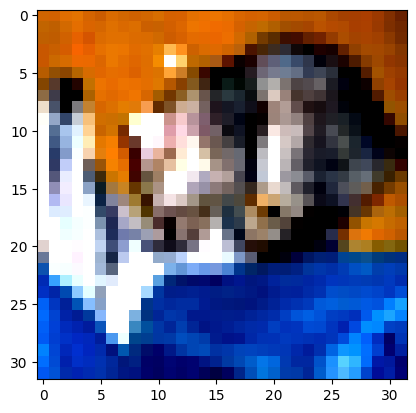

Ground-truth label: 3, Model prediction: 3


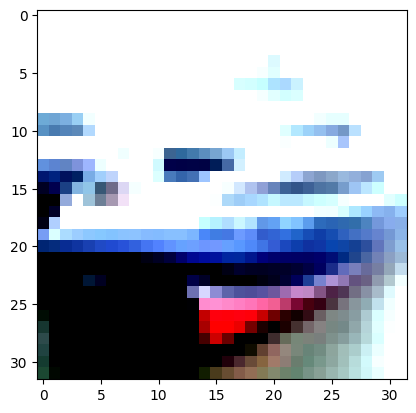

Ground-truth label: 8, Model prediction: 1


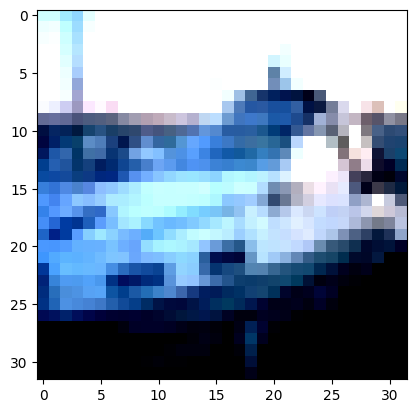

Ground-truth label: 8, Model prediction: 8


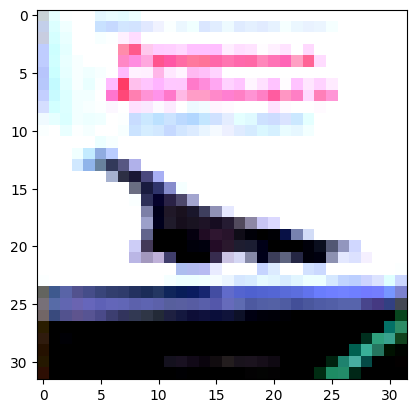

Ground-truth label: 0, Model prediction: 0


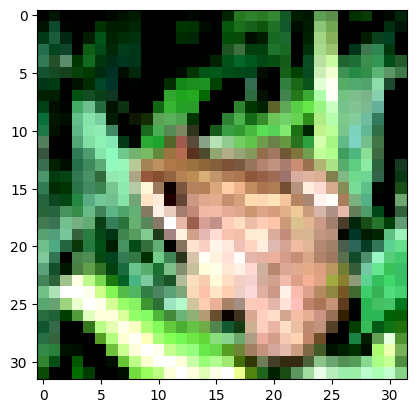

Ground-truth label: 6, Model prediction: 6


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Define the transform for CIFAR-10 data (already done)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

# Function to convert tensor to image for display
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert tensor to HWC format
    plt.show()

'''
# Load CIFAR-10 test data
test_data = datasets.CIFAR10(
    "./data", train=False, download=True, transform=transform)'''


# Loop through the test data and make predictions for each image
for idx in range(5):  # Loop through the first 10 test images
    image, label = test_data[idx]
    image = image.unsqueeze(0).cpu()  # Add batch dimension and move to GPU
    label = label  # Ground truth label

    # Get the model's prediction
    with torch.no_grad():  # Disable gradient computation
        output = model(image)
        _, predicted_label = torch.max(output, 1)  # Get the predicted label
    # Show the image
    imshow(image.squeeze(0))  # Remove the batch dimension to display the image
    # Print the ground-truth label and the predicted label
    print(f'Ground-truth label: {label}, Model prediction: {predicted_label.item()}')


In [8]:
idx = 144
image = test_data[idx][0].view(1,3,32,32).cpu()
label = data = test_data[idx][1]
print('Ground-truth label:', label)
print('Model prediction:', model(image))

Ground-truth label: 8
Model prediction: tensor([[-0.6928, -3.5109, -1.4360, -3.7056, -4.8990, -5.3603, -4.0330, -2.6409,
          2.1195, -5.5656]], grad_fn=<AddmmBackward0>)


## Use `auto_LiRPA` to obtain provable lower and outer bounds under perturbation

There are three essential steps to use `auto_LiRPA`:

1.   Wrap a predefined computation in a `nn.Module` object with `auto_LiRPA.BoundedModule`;
2.   Define perturbation as a `BoundedTensor` (or `BoundedParameter` if you are perturbing model weights);
3.   Use the `compute_bounds()` method to obtain lower and upper bounds of the computational graph defined in `nn.Module`.



In [9]:
# Step 1: wrap model with BoundedModule.
bounded_model = BoundedModule(model=model, global_input=torch.zeros_like(image))
bounded_model.eval()

In [10]:
# Step 2: define perturbation. Here we use a Linf perturbation on input image.
eps = 0.00001
norm = np.inf
ptb = PerturbationLpNorm(norm=norm, eps=eps)
# Input tensor is wrapped in a BoundedTensor object.
bounded_image = BoundedTensor(x=image, ptb=ptb)
# We can use BoundedTensor to get model prediction as usual. Regular forward/backward propagation is unaffected.
print('Model prediction:', bounded_model(bounded_image))

Model prediction: tensor([[-0.6928, -3.5109, -1.4360, -3.7056, -4.8990, -5.3603, -4.0330, -2.6409,
          2.1195, -5.5656]])


As you can see above, the `BoundedModule` object wrapped by `auto_LiRPA` can be used the same way as a regular Pytorch model, with a `BoundedTensor` as its input.

Bounding method: backward (CROWN, DeepPoly)
Ground-truth label: 8
Model prediction: tensor([[-0.6928, -3.5109, -1.4360, -3.7056, -4.8990, -5.3603, -4.0330, -2.6409,
          2.1195, -5.5656]])
f_0(x_0):   -0.694 <= f_0(x_0+delta) <=   -0.691
f_1(x_0):   -3.513 <= f_1(x_0+delta) <=   -3.509
f_2(x_0):   -1.438 <= f_2(x_0+delta) <=   -1.434
f_3(x_0):   -3.706 <= f_3(x_0+delta) <=   -3.705
f_4(x_0):   -4.900 <= f_4(x_0+delta) <=   -4.898
f_5(x_0):   -5.362 <= f_5(x_0+delta) <=   -5.359
f_6(x_0):   -4.034 <= f_6(x_0+delta) <=   -4.032
f_7(x_0):   -2.643 <= f_7(x_0+delta) <=   -2.639
f_8(x_0):    2.117 <= f_8(x_0+delta) <=    2.122
f_9(x_0):   -5.567 <= f_9(x_0+delta) <=   -5.564


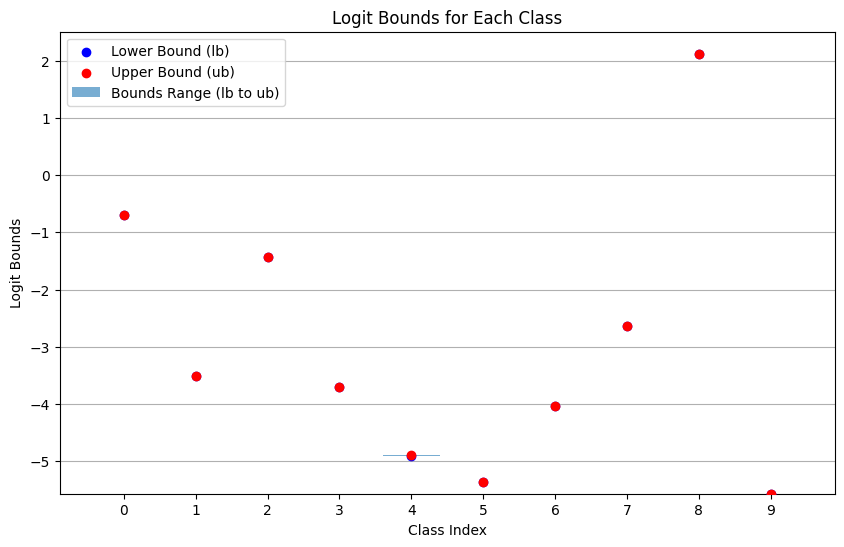

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
# Step 3: compute bounds using the compute_bounds() method.
print('Bounding method: backward (CROWN, DeepPoly)')
with torch.no_grad():  # If gradients of the bounds are not needed, we can use no_grad to save memory.
  lb, ub = bounded_model.compute_bounds(x=(bounded_image,), method='CROWN')

# Auxillary function to print bounds.
def print_bounds(lb, ub):
    lb = lb.detach().cpu().numpy()
    ub = ub.detach().cpu().numpy()
    for j in range(10):
        print("f_{j}(x_0): {l:8.3f} <= f_{j}(x_0+delta) <= {u:8.3f}".format(
            j=j, l=lb[0][j], u=ub[0][j], r=ub[0][j] - lb[0][j]))
print('Ground-truth label:', label)
print('Model prediction:', model(image))
print_bounds(lb, ub)


def plot_bounds(lb, ub):
    lb = lb.detach().cpu().numpy()
    ub = ub.detach().cpu().numpy()
    x = np.arange(len(lb[0]))  # Class indices
    plt.figure(figsize=(10, 6))
    plt.bar(x, ub[0] - lb[0], bottom=lb[0], alpha=0.6, label='Bounds Range (lb to ub)')
    plt.scatter(x, lb[0], color='blue', label='Lower Bound (lb)', zorder=5)
    plt.scatter(x, ub[0], color='red', label='Upper Bound (ub)', zorder=5)
    plt.xlabel('Class Index')
    plt.ylabel('Logit Bounds')
    plt.title('Logit Bounds for Each Class')
    plt.xticks(x)
    plt.legend()
    plt.grid(axis='y')
    plt.show()

plot_bounds(lb, ub)

Local perturbation

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Files already downloaded and verified
Image 1:
Ground-truth label: 3, Model prediction: 3
f_0(x_0):   -3.110 <= f_0(x_0+delta) <=   -3.108
f_1(x_0):   -4.583 <= f_1(x_0+delta) <=   -4.579
f_2(x_0):   -3.746 <= f_2(x_0+delta) <=   -3.744
f_3(x_0):    1.185 <= f_3(x_0+delta) <=    1.188
f_4(x_0):   -5.357 <= f_4(x_0+delta) <=   -5.354
f_5(x_0):   -0.314 <= f_5(x_0+delta) <=   -0.311
f_6(x_0):   -0.002 <= f_6(x_0+delta) <=    0.001
f_7(x_0):   -5.323 <= f_7(x_0+delta) <=   -5.320
f_8(x_0):    1.123 <= f_8(x_0+delta) <=    1.127
f_9(x_0):   -4.339 <= f_9(x_0+delta) <=   -4.336


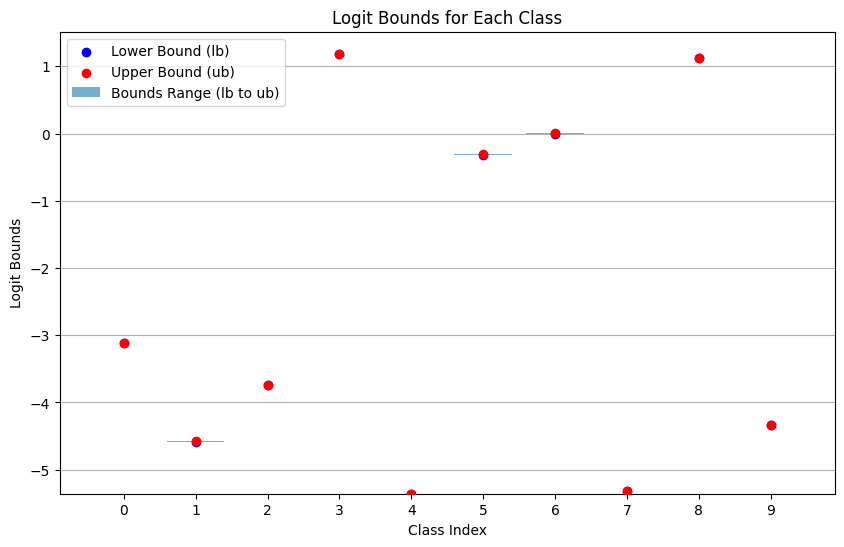

Image 2:
Ground-truth label: 8, Model prediction: 1
f_0(x_0):    2.261 <= f_0(x_0+delta) <=    2.263
f_1(x_0):    5.627 <= f_1(x_0+delta) <=    5.631
f_2(x_0):   -5.303 <= f_2(x_0+delta) <=   -5.301
f_3(x_0):   -6.121 <= f_3(x_0+delta) <=   -6.119
f_4(x_0):   -7.061 <= f_4(x_0+delta) <=   -7.058
f_5(x_0):   -8.492 <= f_5(x_0+delta) <=   -8.489
f_6(x_0):   -7.028 <= f_6(x_0+delta) <=   -7.025
f_7(x_0):   -9.055 <= f_7(x_0+delta) <=   -9.051
f_8(x_0):    3.797 <= f_8(x_0+delta) <=    3.800
f_9(x_0):   -0.918 <= f_9(x_0+delta) <=   -0.914


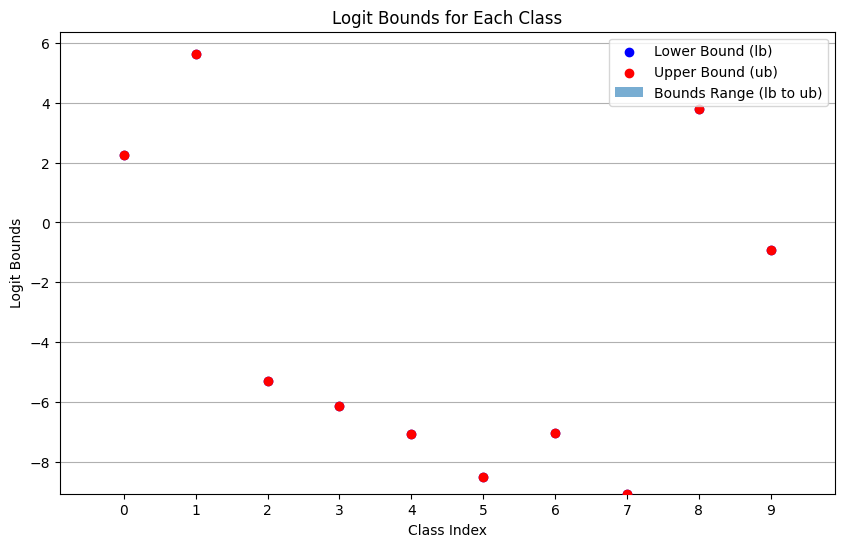

Image 3:
Ground-truth label: 8, Model prediction: 8
f_0(x_0):    0.421 <= f_0(x_0+delta) <=    0.424
f_1(x_0):    0.625 <= f_1(x_0+delta) <=    0.629
f_2(x_0):   -2.774 <= f_2(x_0+delta) <=   -2.771
f_3(x_0):   -3.929 <= f_3(x_0+delta) <=   -3.927
f_4(x_0):   -2.879 <= f_4(x_0+delta) <=   -2.876
f_5(x_0):   -6.025 <= f_5(x_0+delta) <=   -6.021
f_6(x_0):   -6.998 <= f_6(x_0+delta) <=   -6.995
f_7(x_0):   -4.941 <= f_7(x_0+delta) <=   -4.938
f_8(x_0):    2.983 <= f_8(x_0+delta) <=    2.988
f_9(x_0):   -1.285 <= f_9(x_0+delta) <=   -1.279


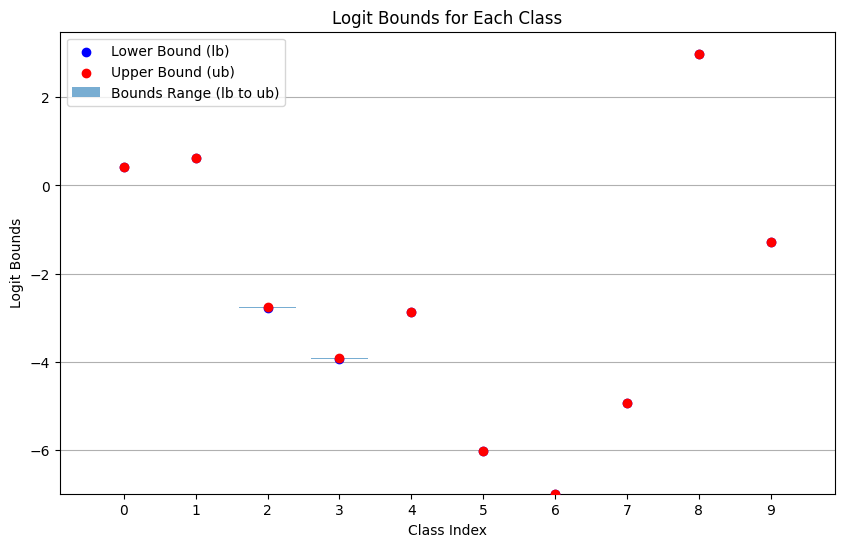

Image 4:
Ground-truth label: 0, Model prediction: 0
f_0(x_0):    4.262 <= f_0(x_0+delta) <=    4.266
f_1(x_0):   -2.826 <= f_1(x_0+delta) <=   -2.823
f_2(x_0):   -1.824 <= f_2(x_0+delta) <=   -1.820
f_3(x_0):   -2.702 <= f_3(x_0+delta) <=   -2.699
f_4(x_0):   -2.663 <= f_4(x_0+delta) <=   -2.660
f_5(x_0):   -5.161 <= f_5(x_0+delta) <=   -5.157
f_6(x_0):   -5.271 <= f_6(x_0+delta) <=   -5.268
f_7(x_0):   -5.641 <= f_7(x_0+delta) <=   -5.636
f_8(x_0):    0.872 <= f_8(x_0+delta) <=    0.878
f_9(x_0):   -4.695 <= f_9(x_0+delta) <=   -4.690


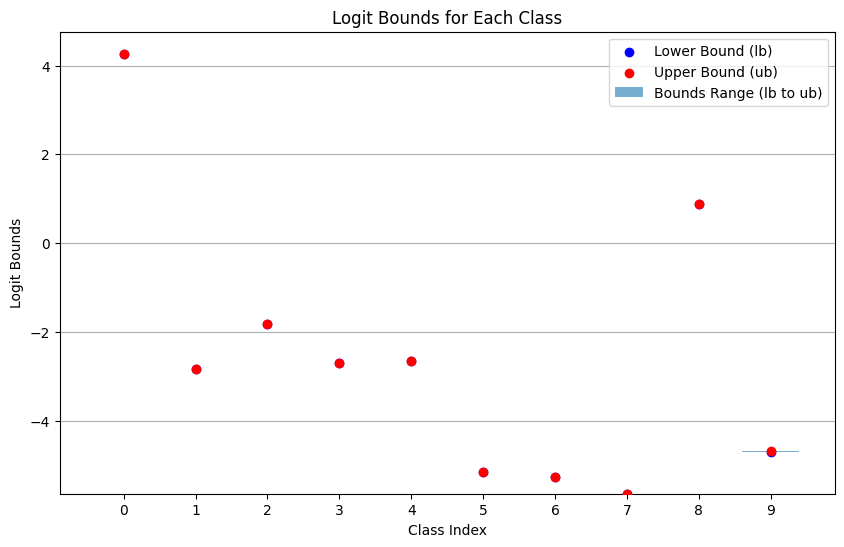

Image 5:
Ground-truth label: 6, Model prediction: 6
f_0(x_0):   -6.816 <= f_0(x_0+delta) <=   -6.813
f_1(x_0):  -10.223 <= f_1(x_0+delta) <=  -10.220
f_2(x_0):    0.296 <= f_2(x_0+delta) <=    0.299
f_3(x_0):   -1.064 <= f_3(x_0+delta) <=   -1.062
f_4(x_0):    0.081 <= f_4(x_0+delta) <=    0.083
f_5(x_0):   -4.456 <= f_5(x_0+delta) <=   -4.454
f_6(x_0):    4.878 <= f_6(x_0+delta) <=    4.881
f_7(x_0):   -5.525 <= f_7(x_0+delta) <=   -5.523
f_8(x_0):   -7.191 <= f_8(x_0+delta) <=   -7.186
f_9(x_0):   -6.024 <= f_9(x_0+delta) <=   -6.021


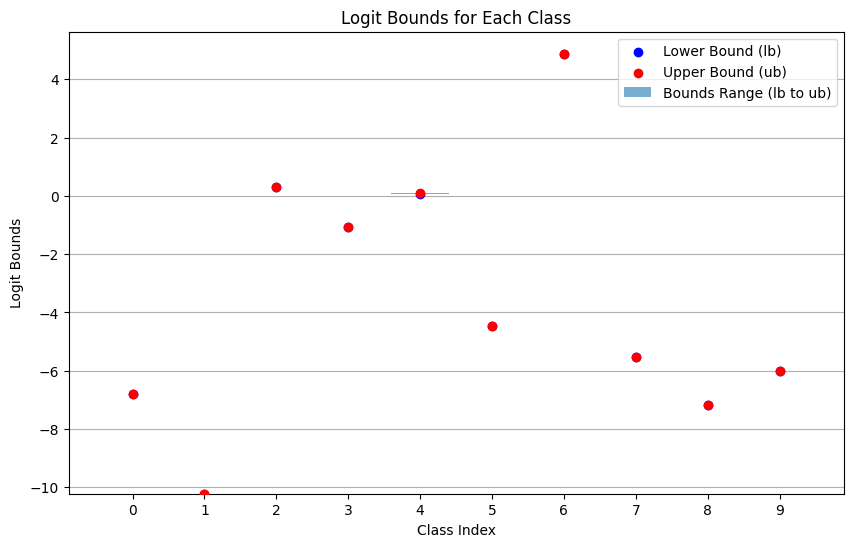

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Define the transform for CIFAR-10 data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])


# Load CIFAR-10 test data
test_data = datasets.CIFAR10(
    "./data", train=False, download=True, transform=transform)


# Assuming you have the 'bounded_model' and necessary functions for bounding
# BoundedModule and PerturbationLpNorm must be defined as part of your framework

# Step 1: Wrap the model with BoundedModule
bounded_model = BoundedModule(model=model, global_input=torch.zeros_like(image.cpu()))
bounded_model.eval()

# Auxiliary function to print bounds
def print_bounds(lb, ub):
    lb = lb.detach().cpu().numpy()
    ub = ub.detach().cpu().numpy()
    for j in range(10):
        print(f"f_{j}(x_0): {lb[0][j]:8.3f} <= f_{j}(x_0+delta) <= {ub[0][j]:8.3f}")

# Auxiliary function to plot bounds
def plot_bounds(lb, ub):
    lb = lb.detach().cpu().numpy()
    ub = ub.detach().cpu().numpy()
    x = np.arange(len(lb[0]))  # Class indices
    plt.figure(figsize=(10, 6))
    plt.bar(x, ub[0] - lb[0], bottom=lb[0], alpha=0.6, label='Bounds Range (lb to ub)')
    plt.scatter(x, lb[0], color='blue', label='Lower Bound (lb)', zorder=5)
    plt.scatter(x, ub[0], color='red', label='Upper Bound (ub)', zorder=5)
    plt.xlabel('Class Index')
    plt.ylabel('Logit Bounds')
    plt.title('Logit Bounds for Each Class')
    plt.xticks(x)
    plt.legend()
    plt.grid(axis='y')
    plt.show()

# Step 2: Apply local perturbation
def apply_local_perturbation(image, eps=0.0003, perturb_region=(0, 0), patch_size=(3, 3)):
    """
    Apply perturbation to a specific region of the image (e.g., a 3x3 region).
    """
    perturbed_image = image.clone()  # Clone the image to avoid modifying the original
    x_start, y_start = perturb_region  # Get the top-left corner of the perturbation region
    x_end = x_start + patch_size[0]
    y_end = y_start + patch_size[1]

    # Apply perturbation only within the specified region (e.g., 3x3 patch)
    perturbed_image[:, x_start:x_end, y_start:y_end] += eps * torch.randn_like(perturbed_image[:, x_start:x_end, y_start:y_end])

    return perturbed_image

# Step 3: Compute bounds using the compute_bounds() method.
def compute_bounds_for_image(image):
    bounded_image = BoundedTensor(x=perturbed_image, ptb=ptb)  # Wrap the image with BoundedTensor
    with torch.no_grad():  # Disable gradient computation
        lb, ub = bounded_model.compute_bounds(x=(bounded_image,), method='CROWN')
    return lb, ub

# Loop through the first 10 test images
for idx in range(5):
    image, label = test_data[idx]
    image = image.unsqueeze(0).cpu()  # Add batch dimension and move to GPU
    label = label  # Ground truth label

    # Apply local perturbation to a specific region (3x3 patch in the top-left corner)
    perturbed_image = apply_local_perturbation(image, eps=0.003, perturb_region=(0, 0), patch_size=(3, 3))

    # Get the model's prediction using the BoundedTensor
    with torch.no_grad():
        bounded_image = BoundedTensor(x=perturbed_image, ptb=None)  # Wrap the perturbed image
        output = bounded_model(bounded_image)
        _, predicted_label = torch.max(output, 1)

    # Print the ground-truth label and model prediction
    print(f"Image {idx+1}:")
    print(f"Ground-truth label: {label}, Model prediction: {predicted_label.item()}")

    # Compute bounds for the perturbed image
    lb, ub = compute_bounds_for_image(perturbed_image)

    # Print the bounds for each class
    print_bounds(lb, ub)

    # Plot the bounds
    plot_bounds(lb, ub)


Files already downloaded and verified
0.1
Image 1:
Ground-truth label: 3, Model prediction: 3
f_0(x_0):   -3.103 <= f_0(x_0+delta) <=   -3.103
f_1(x_0):   -4.666 <= f_1(x_0+delta) <=   -4.666
f_2(x_0):   -3.687 <= f_2(x_0+delta) <=   -3.687
f_3(x_0):    1.207 <= f_3(x_0+delta) <=    1.207
f_4(x_0):   -5.242 <= f_4(x_0+delta) <=   -5.242
f_5(x_0):   -0.279 <= f_5(x_0+delta) <=   -0.279
f_6(x_0):    0.054 <= f_6(x_0+delta) <=    0.054
f_7(x_0):   -5.327 <= f_7(x_0+delta) <=   -5.327
f_8(x_0):    1.071 <= f_8(x_0+delta) <=    1.071
f_9(x_0):   -4.318 <= f_9(x_0+delta) <=   -4.318
1
Image 2:
Ground-truth label: 8, Model prediction: 1
Image 3:
Ground-truth label: 8, Model prediction: 8
f_0(x_0):    0.522 <= f_0(x_0+delta) <=    0.522
f_1(x_0):    0.557 <= f_1(x_0+delta) <=    0.557
f_2(x_0):   -2.761 <= f_2(x_0+delta) <=   -2.761
f_3(x_0):   -3.964 <= f_3(x_0+delta) <=   -3.964
f_4(x_0):   -2.826 <= f_4(x_0+delta) <=   -2.826
f_5(x_0):   -6.049 <= f_5(x_0+delta) <=   -6.049
f_6(x_0):   -7.0

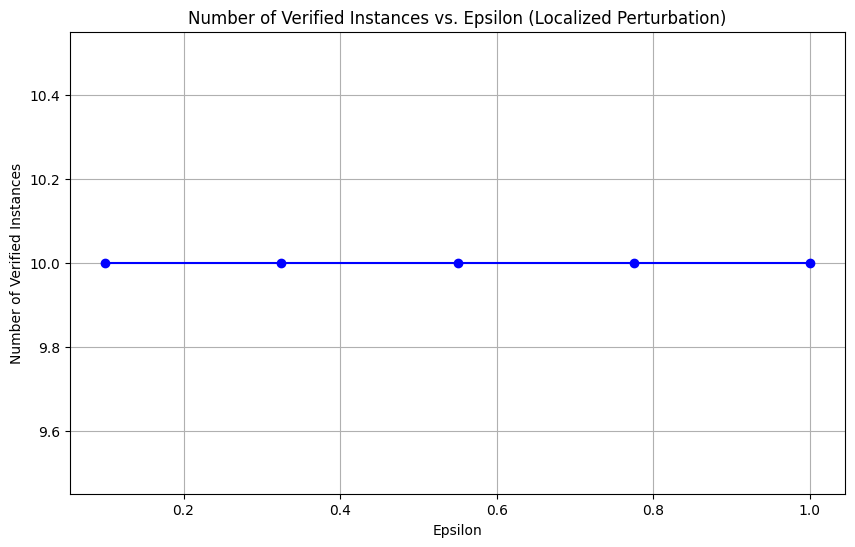

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Define the transform for CIFAR-10 data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])


# Load CIFAR-10 test data
test_data = datasets.CIFAR10(
    "./data", train=False, download=True, transform=transform)


# Assuming you have the 'bounded_model' and necessary functions for bounding
# BoundedModule and PerturbationLpNorm must be defined as part of your framework

# Step 1: Wrap the model with BoundedModule
bounded_model = BoundedModule(model=model, global_input=torch.zeros_like(image.cpu()))
bounded_model.eval()

# Auxiliary function to print bounds
def print_bounds(lb, ub):
    lb = lb.detach().cpu().numpy()
    ub = ub.detach().cpu().numpy()
    for j in range(10):
        print(f"f_{j}(x_0): {lb[0][j]:8.3f} <= f_{j}(x_0+delta) <= {ub[0][j]:8.3f}")

# Auxiliary function to plot bounds
def plot_bounds(lb, ub):
    lb = lb.detach().cpu().numpy()
    ub = ub.detach().cpu().numpy()
    x = np.arange(len(lb[0]))  # Class indices
    plt.figure(figsize=(10, 6))
    plt.bar(x, ub[0] - lb[0], bottom=lb[0], alpha=0.6, label='Bounds Range (lb to ub)')
    plt.scatter(x, lb[0], color='blue', label='Lower Bound (lb)', zorder=5)
    plt.scatter(x, ub[0], color='red', label='Upper Bound (ub)', zorder=5)
    plt.xlabel('Class Index')
    plt.ylabel('Logit Bounds')
    plt.title('Logit Bounds for Each Class')
    plt.xticks(x)
    plt.legend()
    plt.grid(axis='y')
    plt.show()


# Step 3: Compute bounds using the compute_bounds() method.
def compute_bounds_for_image(image):
    bounded_image = BoundedTensor(x=image, ptb=ptb)  # Wrap the image with BoundedTensor
    with torch.no_grad():  # Disable gradient computation
        lb, ub = bounded_model.compute_bounds(x=(bounded_image,), method='CROWN')
    return lb, ub


# Experiment setup
eps_values = np.linspace(0.1, 1, 5)
num_images = 15
verified_counts = []

# Function to apply localized perturbation
def apply_localized_perturbation(image, eps, perturb_region=(20, 10), patch_size=(5, 5)):
    perturbed_image = image.clone()  # Clone the image
    x_start, y_start = perturb_region
    x_end, y_end = x_start + patch_size[0], y_start + patch_size[1]

    # Apply perturbation only to the specified region
    perturbed_image[:, :, x_start:x_end, y_start:y_end] += (
        eps * torch.randn_like(perturbed_image[:, :, x_start:x_end, y_start:y_end])
    )
    return perturbed_image

# Iterate over each epsilon value
for eps in eps_values:
    verified_count = 0  # Counter for verified instances
    print(eps)
    ptb = PerturbationLpNorm(norm=norm, eps=0)
    # Process the first 100 test images
    for idx in range(num_images):
        image, label = test_data[idx]
        image = image.unsqueeze(0).cpu()  # Add batch dimension and move to GPU

        # Apply localized perturbation
        perturb_region = (20, 10)  # Top-left corner as the perturbation region
        perturbed_image = apply_localized_perturbation(image, eps, perturb_region)

        # Wrap the perturbed image with BoundedTensor
        bounded_image = BoundedTensor(x=perturbed_image,ptb=ptb)

        # Get the model's prediction
        with torch.no_grad():
            output = bounded_model(bounded_image)
            _, predicted_label = torch.max(output, 1)
            # Print the ground-truth label and model prediction
        print(f"Image {idx+1}:")
        print(f"Ground-truth label: {label}, Model prediction: {predicted_label.item()}")

          # Compute bounds for the perturbed image
        #lb, ub = compute_bounds_for_image(perturbed_image)

        # Print the bounds for each class
        #print_bounds(lb, ub)

        # Check if ground truth matches prediction
        if predicted_label.item() == label:
            # Compute bounds for the perturbed image
            lb, ub = bounded_model.compute_bounds(x=(bounded_image,), method='CROWN')
            print_bounds(lb, ub)

            # Extract lb and ub as numpy arrays
            lb = lb.detach().cpu().numpy()
            ub = ub.detach().cpu().numpy()

            # Check the condition for f_{label+1}(x_0)
            next_class = (label ) % 10  # Wrap around for class index
            if lb[0][next_class] > max([ub[0][i] for i in range(10) if i != next_class]):
                verified_count += 1
                print(verified_count)

    # Store the verified count for this epsilon
    verified_counts.append(verified_count)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(eps_values, verified_counts, marker='o', linestyle='-', color='b')
plt.title('Number of Verified Instances vs. Epsilon (Localized Perturbation)')
plt.xlabel('Epsilon')
plt.ylabel('Number of Verified Instances')
plt.grid()
plt.show()


MNIST dataset

In [ ]:
'''DenseNet in PyTorch.
https://github.com/kuangliu/pytorch-cifar
'''


import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=True)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=True)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        # out = self.conv1(F.relu(x))
        # out = self.conv2(F.relu(out))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=True)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=True)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        # out_planes = int(math.floor(num_planes*reduction))
        # self.trans3 = Transition(num_planes, out_planes)
        # num_planes = out_planes

        # self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        # num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear1 = nn.Linear(14336, 512)
        self.linear2 = nn.Linear(512, num_classes)


    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.dense3(out)
        out = F.relu(self.bn(out))
        out = torch.flatten(out, 1)
        out = F.relu(self.linear1(out))
        out = self.linear2(out)

        return out

def Densenet_cifar_32(in_ch=3, in_dim=32):
    return DenseNet(Bottleneck, [2,4,4], growth_rate=32)

if __name__ == "__main__":
    from thop import profile

    net = Densenet_cifar_32()
    x = torch.randn(1,3,32,32)
    y = net(x)
    print(net)
    macs, params = profile(net, (torch.randn(1, 3, 32, 32),))
    print(macs / 1000000, params / 1000000)  # 6830M, 7M
    print(y)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


ModuleNotFoundError: No module named 'thop'

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm  # Ensure you have the correct auto_LiRPA library
from torch.utils.data import DataLoader

# Define the transformation for MNIST data
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize grayscale values
    lambda x: x.repeat(3, 1, 1)  # Duplicate the grayscale channel to create RGB
])

# Load MNIST test data
mnist_test_data = datasets.MNIST("./data", train=False, download=True, transform=transform)

# Define the data loader
test_loader = DataLoader(mnist_test_data, batch_size=1, shuffle=False)

# Assuming you have a pretrained model named `model`
# Wrap the model with BoundedModule
model.eval()  # Ensure the model is in evaluation mode
bounded_model = BoundedModule(model, torch.zeros_like(next(iter(test_loader))[0]))

# Define auxiliary functions
def print_bounds(lb, ub):
    lb = lb.detach().cpu().numpy()
    ub = ub.detach().cpu().numpy()
    for j in range(10):  # Loop over classes
        print(f"f_{j}(x_0): {lb[0][j]:8.3f} <= f_{j}(x_0+delta) <= {ub[0][j]:8.3f}")

def plot_bounds(lb, ub):
    lb = lb.detach().cpu().numpy()
    ub = ub.detach().cpu().numpy()
    x = np.arange(len(lb[0]))
    plt.figure(figsize=(10, 6))
    plt.bar(x, ub[0] - lb[0], bottom=lb[0], alpha=0.6, label="Bounds Range (lb to ub)")
    plt.scatter(x, lb[0], color="blue", label="Lower Bound (lb)", zorder=5)
    plt.scatter(x, ub[0], color="red", label="Upper Bound (ub)", zorder=5)
    plt.xlabel("Class Index")
    plt.ylabel("Logit Bounds")
    plt.title("Logit Bounds for Each Class")
    plt.xticks(x)
    plt.legend()
    plt.grid(axis="y")
    plt.show()

# Function to apply localized perturbation
def apply_localized_perturbation(image, eps, perturb_region=(0, 0), patch_size=(3, 3)):
    perturbed_image = image.clone()
    x_start, y_start = perturb_region
    x_end, y_end = x_start + patch_size[0], y_start + patch_size[1]
    perturbed_image[:, :, x_start:x_end, y_start:y_end] += (
        eps * torch.randn_like(perturbed_image[:, :, x_start:x_end, y_start:y_end])
    )
    return perturbed_image

# Compute bounds for an image
def compute_bounds_for_image(image, ptb):
    bounded_image = BoundedTensor(x=image, ptb=ptb)
    with torch.no_grad():
        lb, ub = bounded_model.compute_bounds(x=(bounded_image,), method="CROWN")
    return lb, ub

# Experiment parameters
eps_values = np.linspace(0.001, 0.004, 4)
num_images = 15
norm = float("inf")  # Define the norm for perturbation
verified_counts = []

# Iterate over each epsilon value
for eps in eps_values:
    verified_count = 0  # Counter for verified instances
    print(f"Testing with epsilon: {eps}")
    ptb = PerturbationLpNorm(norm=norm, eps=eps)

    for idx, (image, label) in enumerate(test_loader):
        if idx >= num_images:  # Limit the number of images processed
            break

        image = image.cpu()  # Ensure image is on CPU

        # Apply localized perturbation
        perturb_region = (0, 0)  # Top-left corner
        perturbed_image = apply_localized_perturbation(image, eps, perturb_region)

        # Wrap the perturbed image with BoundedTensor
        bounded_image = BoundedTensor(x=perturbed_image, ptb=ptb)

        # Get the model's prediction
        with torch.no_grad():
            output = bounded_model(bounded_image)
            _, predicted_label = torch.max(output, 1)

        # Print ground-truth label and model prediction
        print(f"Image {idx+1}:")
        print(f"Ground-truth label: {label.item()}, Model prediction: {predicted_label.item()}")

        # Compute bounds for the perturbed image
        lb, ub = compute_bounds_for_image(perturbed_image, ptb)

        # Print the bounds for each class
        print_bounds(lb, ub)

        # Check robustness
        if predicted_label.item() == label.item():
            lb_np, ub_np = lb.detach().cpu().numpy(), ub.detach().cpu().numpy()
            next_class = (label.item() + 1) % 10  # Wrap around class index
            if lb_np[0][label.item()] > max(ub_np[0][i] for i in range(10) if i != label.item()):
                verified_count += 1

    verified_counts.append(verified_count)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(eps_values, verified_counts, marker="o", linestyle="-", color="b")
plt.title("Number of Verified Instances vs. Epsilon (Localized Perturbation)")
plt.xlabel("Epsilon")
plt.ylabel("Number of Verified Instances")
plt.grid()
plt.show()


Testing with epsilon: 0.001
Image 1:
Ground-truth label: 7, Model prediction: 2
f_0(x_0):    0.731 <= f_0(x_0+delta) <=    1.461
f_1(x_0):   -5.493 <= f_1(x_0+delta) <=   -4.814
f_2(x_0):    4.232 <= f_2(x_0+delta) <=    4.867
f_3(x_0):   -2.258 <= f_3(x_0+delta) <=   -1.805
f_4(x_0):   -2.372 <= f_4(x_0+delta) <=   -1.681
f_5(x_0):   -4.733 <= f_5(x_0+delta) <=   -4.141
f_6(x_0):   -2.624 <= f_6(x_0+delta) <=   -2.038
f_7(x_0):   -6.249 <= f_7(x_0+delta) <=   -5.464
f_8(x_0):   -2.474 <= f_8(x_0+delta) <=   -1.584
f_9(x_0):   -6.154 <= f_9(x_0+delta) <=   -5.523
Image 2:
Ground-truth label: 2, Model prediction: 2
f_0(x_0):   -1.943 <= f_0(x_0+delta) <=   -1.338
f_1(x_0):   -5.601 <= f_1(x_0+delta) <=   -4.841
f_2(x_0):    1.531 <= f_2(x_0+delta) <=    2.202
f_3(x_0):   -0.722 <= f_3(x_0+delta) <=   -0.312
f_4(x_0):   -3.933 <= f_4(x_0+delta) <=   -3.327
f_5(x_0):   -0.973 <= f_5(x_0+delta) <=   -0.360
f_6(x_0):   -3.290 <= f_6(x_0+delta) <=   -2.748
f_7(x_0):   -3.254 <= f_7(x_0+delta

KeyboardInterrupt: 

In [ ]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Define the transform for CIFAR-10 data (already done)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])
'''
# Load CIFAR-10 test data
test_data = datasets.CIFAR10(
    "./data", train=False, download=True, transform=transform)
'''

# Assuming you have the 'bounded_model' and necessary functions for bounding
# BoundedModule and PerturbationLpNorm must be defined as part of your framework

# Step 1: Wrap the model with BoundedModule
# Assume BoundedModule is part of the library you're using (such as verifier or custom implementation)
bounded_model = BoundedModule(model=model, global_input=torch.zeros_like(image))
bounded_model.eval()

# Step 2: Define the perturbation (L∞ perturbation)
eps = 0.0003  # Perturbation epsilon
norm = np.inf  # L∞ norm (maximum perturbation per pixel)
ptb = PerturbationLpNorm(norm=norm, eps=eps)

# Auxiliary function to print bounds
def print_bounds(lb, ub):
    lb = lb.detach().cpu().numpy()
    ub = ub.detach().cpu().numpy()
    for j in range(10):
        print(f"f_{j}(x_0): {lb[0][j]:8.3f} <= f_{j}(x_0+delta) <= {ub[0][j]:8.3f}")

# Auxiliary function to plot bounds
def plot_bounds(lb, ub):
    lb = lb.detach().cpu().numpy()
    ub = ub.detach().cpu().numpy()
    x = np.arange(len(lb[0]))  # Class indices
    plt.figure(figsize=(10, 6))
    plt.bar(x, ub[0] - lb[0], bottom=lb[0], alpha=0.6, label='Bounds Range (lb to ub)')
    plt.scatter(x, lb[0], color='blue', label='Lower Bound (lb)', zorder=5)
    plt.scatter(x, ub[0], color='red', label='Upper Bound (ub)', zorder=5)
    plt.xlabel('Class Index')
    plt.ylabel('Logit Bounds')
    plt.title('Logit Bounds for Each Class')
    plt.xticks(x)
    plt.legend()
    plt.grid(axis='y')
    plt.show()

# Step 3: Compute bounds using the compute_bounds() method.
def compute_bounds_for_image(image):
    bounded_image = BoundedTensor(x=image, ptb=ptb)  # Wrap the image with BoundedTensor
    with torch.no_grad():  # Disable gradient computation
        lb, ub = bounded_model.compute_bounds(x=(bounded_image,), method='CROWN')
    return lb, ub

# Loop through the first 10 test images
for idx in range(5):
    image, label = test_data[idx]
    image = image.unsqueeze(0).cuda()  # Add batch dimension and move to GPU
    label = label  # Ground truth label

    # Get the model's prediction using the BoundedTensor
    with torch.no_grad():
        bounded_image = BoundedTensor(x=image, ptb=ptb)  # Wrap the image with BoundedTensor
        output = bounded_model(bounded_image)
        _, predicted_label = torch.max(output, 1)

    # Print the ground-truth label and model prediction
    print(f"Image {idx+1}:")
    print(f"Ground-truth label: {label}, Model prediction: {predicted_label.item()}")

    # Compute bounds for the image
    lb, ub = compute_bounds_for_image(image)

    # Print the bounds for each class
    print_bounds(lb, ub)

    # Plot the bounds
    plot_bounds(lb, ub)


ValueError: expected 4D input (got 3D input)

MNIST Dataset

Ground-truth label: 7
Model prediction: 2
f_0(x_0): -78369.359 <= f_0(x_0+delta) <= 56376.887
f_1(x_0): -93128.234 <= f_1(x_0+delta) <= 63836.801
f_2(x_0): -64304.754 <= f_2(x_0+delta) <= 52334.777
f_3(x_0): -58232.102 <= f_3(x_0+delta) <= 41363.281
f_4(x_0): -75995.367 <= f_4(x_0+delta) <= 51385.715
f_5(x_0): -69588.312 <= f_5(x_0+delta) <= 52669.375
f_6(x_0): -80118.133 <= f_6(x_0+delta) <= 46724.375
f_7(x_0): -93179.273 <= f_7(x_0+delta) <= 64909.906
f_8(x_0): -99546.703 <= f_8(x_0+delta) <= 67060.625
f_9(x_0): -85635.992 <= f_9(x_0+delta) <= 49146.051


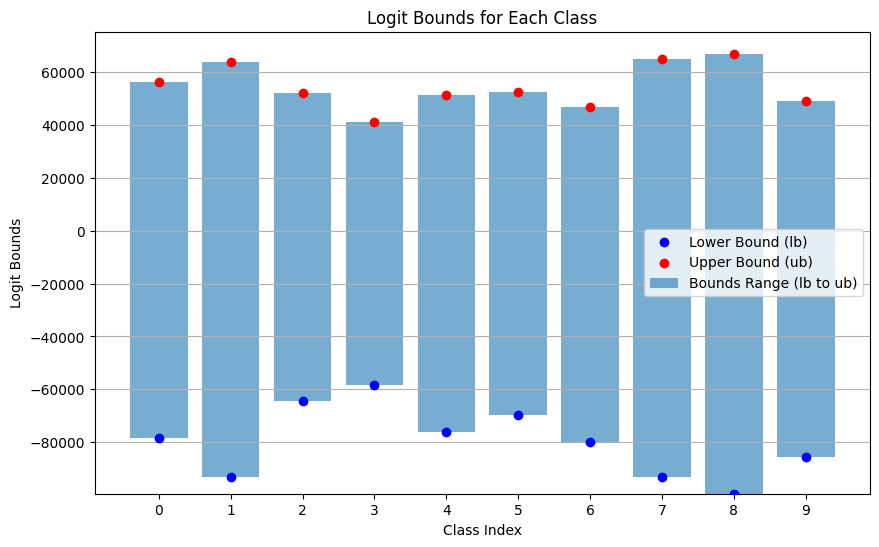

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Resize

# Step 1: Convert MNIST grayscale image to RGB by repeating the grayscale channel 3 times
def convert_to_rgb(image):
    return image.repeat(3, 1, 1)  # Convert grayscale to 3-channel by repeating


# Step 3: Define perturbation and BoundedModule
eps = 0.03  # Perturbation epsilon
norm = np.inf  # L∞ norm
ptb = PerturbationLpNorm(norm=norm, eps=eps)

# Step 4: Load MNIST data and apply perturbation
test_data = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
image, label = test_data[0]  # Pick the first image

# Resize MNIST image to 32x32 to match CIFAR model input size
resize_transform = Resize((32, 32))
image = resize_transform(image)  # Resize image to (32, 32)

image = convert_to_rgb(image).unsqueeze(0).cuda()  # Convert to RGB and add batch dimension
bounded_model = BoundedModule(model=model, global_input=torch.zeros_like(image))
bounded_model.eval()  # Set to evaluation mode

# Step 5: Define BoundedTensor (perturbed image)
bounded_image = BoundedTensor(x=image, ptb=ptb)

# Step 6: Compute bounds using CROWN method
with torch.no_grad():
    lb, ub = bounded_model.compute_bounds(x=(bounded_image,), method='CROWN')

# Auxiliary function to print bounds
def print_bounds(lb, ub):
    lb = lb.detach().cpu().numpy()
    ub = ub.detach().cpu().numpy()
    for j in range(10):  # Assuming a 10-class model
        print(f"f_{j}(x_0): {lb[0][j]:8.3f} <= f_{j}(x_0+delta) <= {ub[0][j]:8.3f}")

# Print bounds and predictions
print('Ground-truth label:', label)
output = model(image)
_, predicted_label = torch.max(output, 1)
print(f'Model prediction: {predicted_label.item()}')
print_bounds(lb, ub)

# Step 7: Plot bounds
def plot_bounds(lb, ub):
    lb = lb.detach().cpu().numpy()
    ub = ub.detach().cpu().numpy()
    x = np.arange(len(lb[0]))  # Class indices
    plt.figure(figsize=(10, 6))
    plt.bar(x, ub[0] - lb[0], bottom=lb[0], alpha=0.6, label='Bounds Range (lb to ub)')
    plt.scatter(x, lb[0], color='blue', label='Lower Bound (lb)', zorder=5)
    plt.scatter(x, ub[0], color='red', label='Upper Bound (ub)', zorder=5)
    plt.xlabel('Class Index')
    plt.ylabel('Logit Bounds')
    plt.title('Logit Bounds for Each Class')
    plt.xticks(x)
    plt.legend()
    plt.grid(axis='y')
    plt.show()

plot_bounds(lb, ub)


Loop:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Image Index: 0
Ground-truth label: 7
Model prediction: 2
f_0(x_0):    1.469 <= f_0(x_0+delta) <=    1.474
f_1(x_0):   -7.851 <= f_1(x_0+delta) <=   -7.847
f_2(x_0):    3.021 <= f_2(x_0+delta) <=    3.025
f_3(x_0):   -0.689 <= f_3(x_0+delta) <=   -0.687
f_4(x_0):   -0.715 <= f_4(x_0+delta) <=   -0.711
f_5(x_0):   -2.791 <= f_5(x_0+delta) <=   -2.787
f_6(x_0):   -2.057 <= f_6(x_0+delta) <=   -2.054
f_7(x_0):   -4.983 <= f_7(x_0+delta) <=   -4.979
f_8(x_0):   -2.241 <= f_8(x_0+delta) <=   -2.237
f_9(x_0):   -6.159 <= f_9(x_0+delta) <=   -6.156


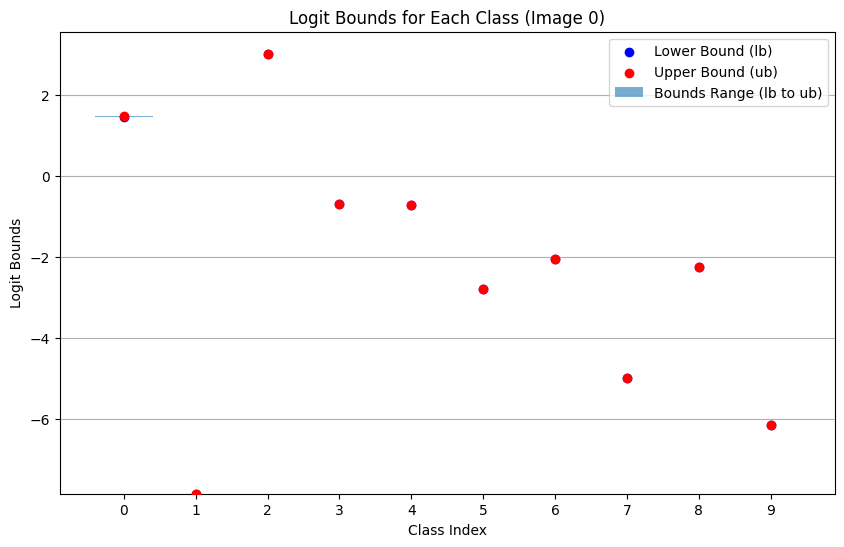


Image Index: 1
Ground-truth label: 2
Model prediction: 2
f_0(x_0):   -1.339 <= f_0(x_0+delta) <=   -1.335
f_1(x_0):   -8.761 <= f_1(x_0+delta) <=   -8.756
f_2(x_0):    1.501 <= f_2(x_0+delta) <=    1.503
f_3(x_0):    0.150 <= f_3(x_0+delta) <=    0.152
f_4(x_0):   -2.098 <= f_4(x_0+delta) <=   -2.096
f_5(x_0):   -0.943 <= f_5(x_0+delta) <=   -0.940
f_6(x_0):   -2.280 <= f_6(x_0+delta) <=   -2.279
f_7(x_0):   -3.822 <= f_7(x_0+delta) <=   -3.820
f_8(x_0):   -1.954 <= f_8(x_0+delta) <=   -1.946
f_9(x_0):   -6.303 <= f_9(x_0+delta) <=   -6.298


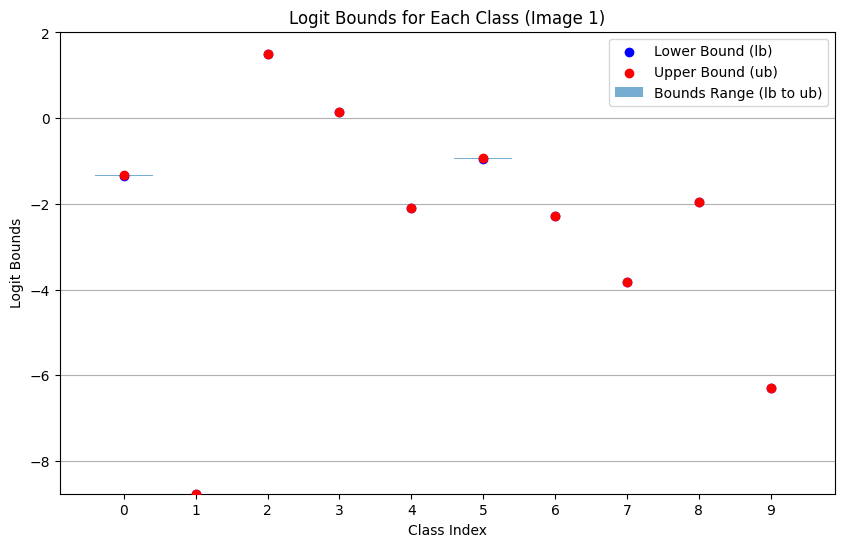


Image Index: 2
Ground-truth label: 1
Model prediction: 2
f_0(x_0):    1.634 <= f_0(x_0+delta) <=    1.636
f_1(x_0):   -7.339 <= f_1(x_0+delta) <=   -7.335
f_2(x_0):    1.756 <= f_2(x_0+delta) <=    1.758
f_3(x_0):   -0.445 <= f_3(x_0+delta) <=   -0.443
f_4(x_0):   -1.798 <= f_4(x_0+delta) <=   -1.797
f_5(x_0):   -1.782 <= f_5(x_0+delta) <=   -1.779
f_6(x_0):   -2.547 <= f_6(x_0+delta) <=   -2.544
f_7(x_0):   -3.858 <= f_7(x_0+delta) <=   -3.854
f_8(x_0):   -0.532 <= f_8(x_0+delta) <=   -0.528
f_9(x_0):   -4.862 <= f_9(x_0+delta) <=   -4.859


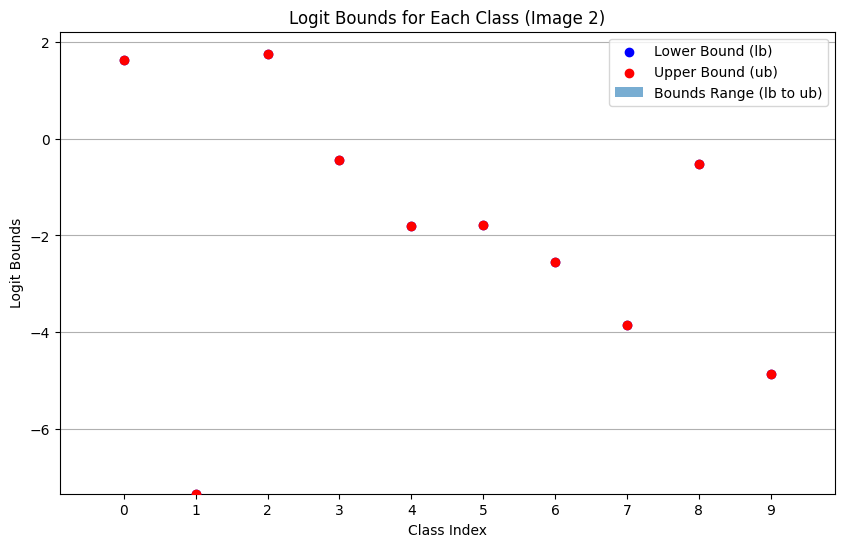


Image Index: 3
Ground-truth label: 0
Model prediction: 2
f_0(x_0):   -2.088 <= f_0(x_0+delta) <=   -2.086
f_1(x_0):   -9.636 <= f_1(x_0+delta) <=   -9.633
f_2(x_0):    1.881 <= f_2(x_0+delta) <=    1.885
f_3(x_0):    0.840 <= f_3(x_0+delta) <=    0.842
f_4(x_0):   -5.597 <= f_4(x_0+delta) <=   -5.594
f_5(x_0):    0.700 <= f_5(x_0+delta) <=    0.703
f_6(x_0):   -1.821 <= f_6(x_0+delta) <=   -1.818
f_7(x_0):   -3.227 <= f_7(x_0+delta) <=   -3.225
f_8(x_0):   -1.919 <= f_8(x_0+delta) <=   -1.914
f_9(x_0):   -7.179 <= f_9(x_0+delta) <=   -7.175


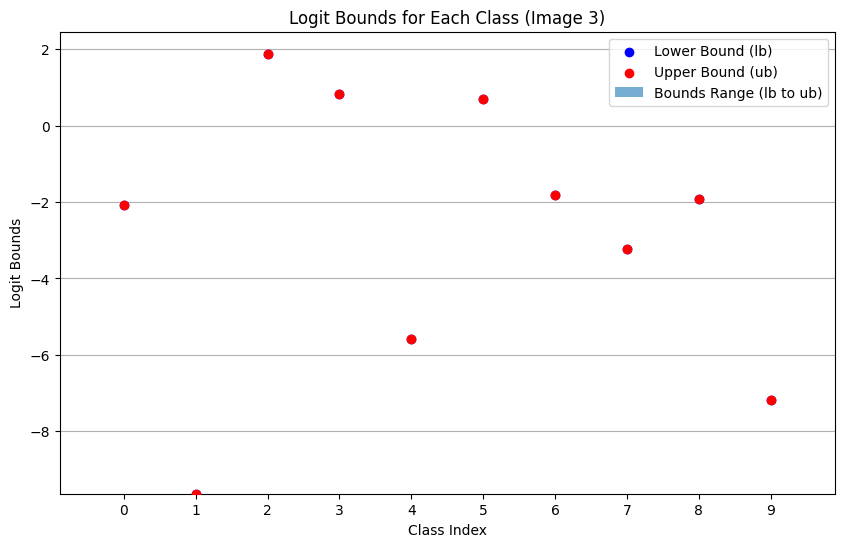


Image Index: 4
Ground-truth label: 4
Model prediction: 3
f_0(x_0):    0.536 <= f_0(x_0+delta) <=    0.541
f_1(x_0):   -8.416 <= f_1(x_0+delta) <=   -8.409
f_2(x_0):    0.566 <= f_2(x_0+delta) <=    0.570
f_3(x_0):    0.749 <= f_3(x_0+delta) <=    0.752
f_4(x_0):   -3.146 <= f_4(x_0+delta) <=   -3.137
f_5(x_0):   -0.021 <= f_5(x_0+delta) <=   -0.014
f_6(x_0):   -2.250 <= f_6(x_0+delta) <=   -2.247
f_7(x_0):   -3.225 <= f_7(x_0+delta) <=   -3.221
f_8(x_0):   -0.795 <= f_8(x_0+delta) <=   -0.784
f_9(x_0):   -4.848 <= f_9(x_0+delta) <=   -4.842


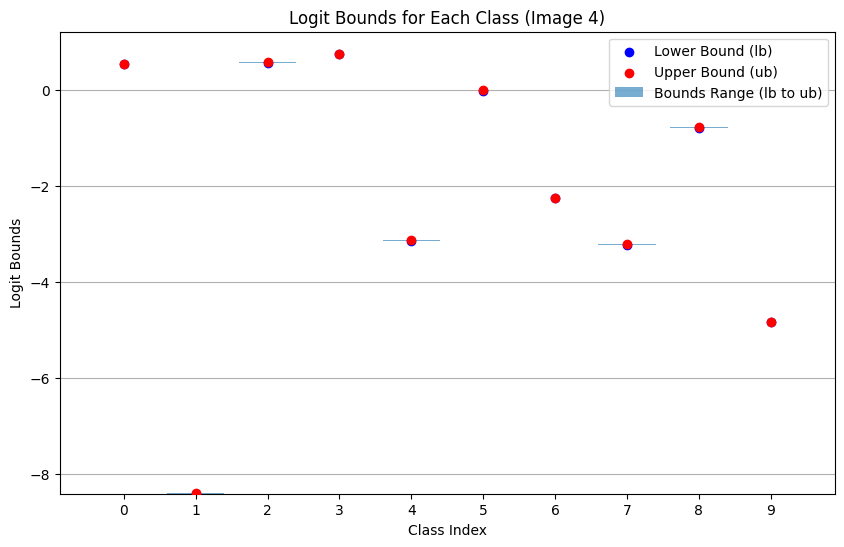


Image Index: 5
Ground-truth label: 1
Model prediction: 2
f_0(x_0):    1.408 <= f_0(x_0+delta) <=    1.410
f_1(x_0):   -7.704 <= f_1(x_0+delta) <=   -7.701
f_2(x_0):    1.535 <= f_2(x_0+delta) <=    1.537
f_3(x_0):   -0.410 <= f_3(x_0+delta) <=   -0.408
f_4(x_0):   -2.032 <= f_4(x_0+delta) <=   -2.031
f_5(x_0):   -1.579 <= f_5(x_0+delta) <=   -1.578
f_6(x_0):   -2.365 <= f_6(x_0+delta) <=   -2.363
f_7(x_0):   -3.812 <= f_7(x_0+delta) <=   -3.810
f_8(x_0):   -0.654 <= f_8(x_0+delta) <=   -0.651
f_9(x_0):   -4.774 <= f_9(x_0+delta) <=   -4.772


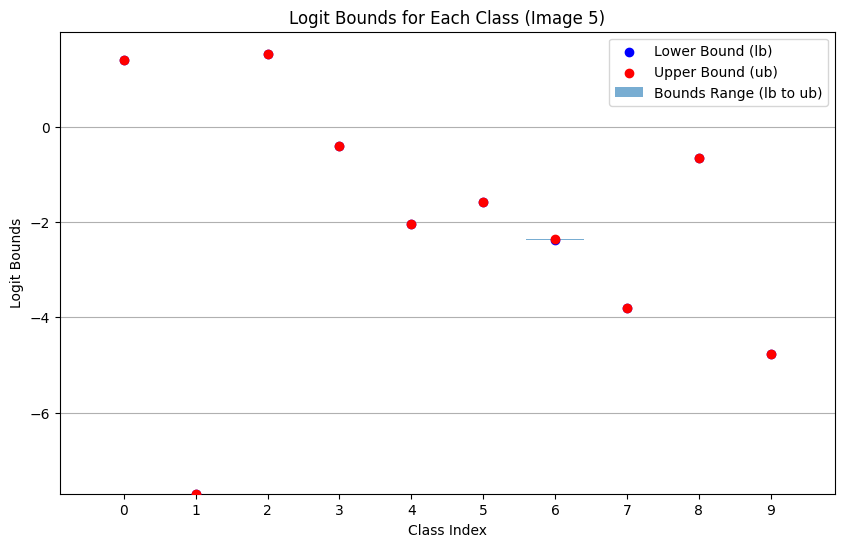


Image Index: 6
Ground-truth label: 4
Model prediction: 2
f_0(x_0):    1.164 <= f_0(x_0+delta) <=    1.165
f_1(x_0):   -8.945 <= f_1(x_0+delta) <=   -8.943
f_2(x_0):    3.068 <= f_2(x_0+delta) <=    3.071
f_3(x_0):   -0.775 <= f_3(x_0+delta) <=   -0.773
f_4(x_0):   -1.653 <= f_4(x_0+delta) <=   -1.650
f_5(x_0):   -2.794 <= f_5(x_0+delta) <=   -2.790
f_6(x_0):   -0.963 <= f_6(x_0+delta) <=   -0.960
f_7(x_0):   -5.818 <= f_7(x_0+delta) <=   -5.815
f_8(x_0):   -2.621 <= f_8(x_0+delta) <=   -2.620
f_9(x_0):   -7.425 <= f_9(x_0+delta) <=   -7.422


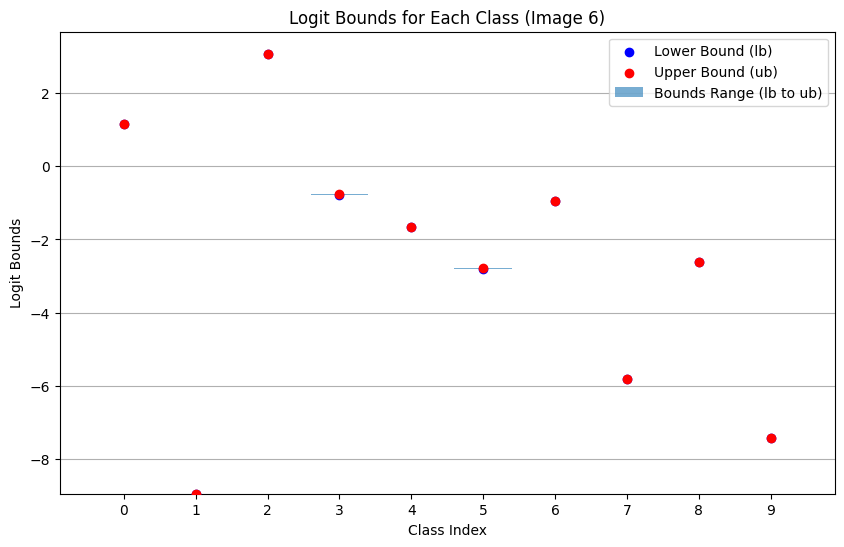


Image Index: 7
Ground-truth label: 9
Model prediction: 2
f_0(x_0):   -0.479 <= f_0(x_0+delta) <=   -0.476
f_1(x_0):   -9.757 <= f_1(x_0+delta) <=   -9.755
f_2(x_0):    1.664 <= f_2(x_0+delta) <=    1.670
f_3(x_0):    0.935 <= f_3(x_0+delta) <=    0.937
f_4(x_0):   -3.441 <= f_4(x_0+delta) <=   -3.435
f_5(x_0):    0.426 <= f_5(x_0+delta) <=    0.428
f_6(x_0):   -1.251 <= f_6(x_0+delta) <=   -1.249
f_7(x_0):   -3.315 <= f_7(x_0+delta) <=   -3.313
f_8(x_0):   -1.897 <= f_8(x_0+delta) <=   -1.891
f_9(x_0):   -7.105 <= f_9(x_0+delta) <=   -7.102


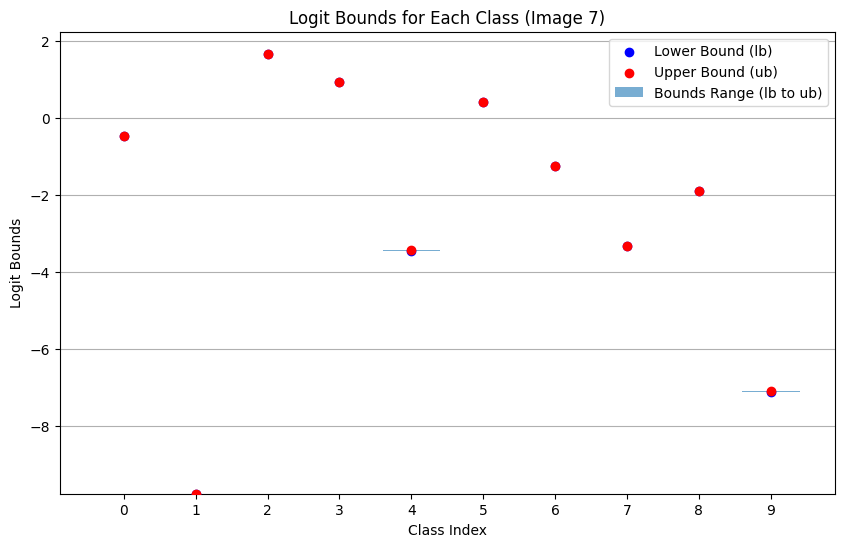


Image Index: 8
Ground-truth label: 5
Model prediction: 0
f_0(x_0):   -0.116 <= f_0(x_0+delta) <=   -0.110
f_1(x_0):   -5.547 <= f_1(x_0+delta) <=   -5.539
f_2(x_0):   -0.116 <= f_2(x_0+delta) <=   -0.111
f_3(x_0):   -0.155 <= f_3(x_0+delta) <=   -0.151
f_4(x_0):   -1.280 <= f_4(x_0+delta) <=   -1.268
f_5(x_0):   -1.074 <= f_5(x_0+delta) <=   -1.065
f_6(x_0):   -2.167 <= f_6(x_0+delta) <=   -2.161
f_7(x_0):   -4.817 <= f_7(x_0+delta) <=   -4.809
f_8(x_0):   -0.165 <= f_8(x_0+delta) <=   -0.158
f_9(x_0):   -5.342 <= f_9(x_0+delta) <=   -5.339


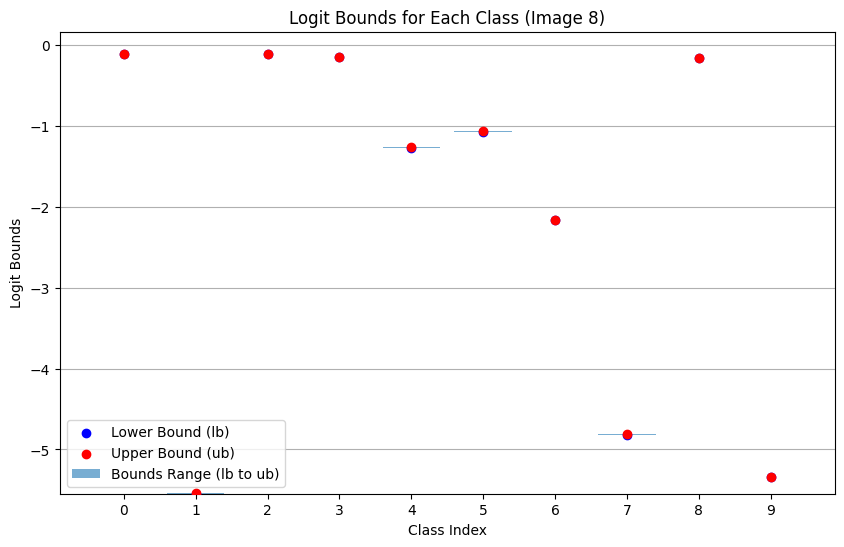


Image Index: 9
Ground-truth label: 9
Model prediction: 2
f_0(x_0):    0.255 <= f_0(x_0+delta) <=    0.260
f_1(x_0):   -8.272 <= f_1(x_0+delta) <=   -8.269
f_2(x_0):    2.888 <= f_2(x_0+delta) <=    2.891
f_3(x_0):   -0.367 <= f_3(x_0+delta) <=   -0.365
f_4(x_0):   -3.287 <= f_4(x_0+delta) <=   -3.280
f_5(x_0):   -1.190 <= f_5(x_0+delta) <=   -1.188
f_6(x_0):   -0.972 <= f_6(x_0+delta) <=   -0.968
f_7(x_0):   -6.089 <= f_7(x_0+delta) <=   -6.082
f_8(x_0):   -2.877 <= f_8(x_0+delta) <=   -2.870
f_9(x_0):   -8.127 <= f_9(x_0+delta) <=   -8.124


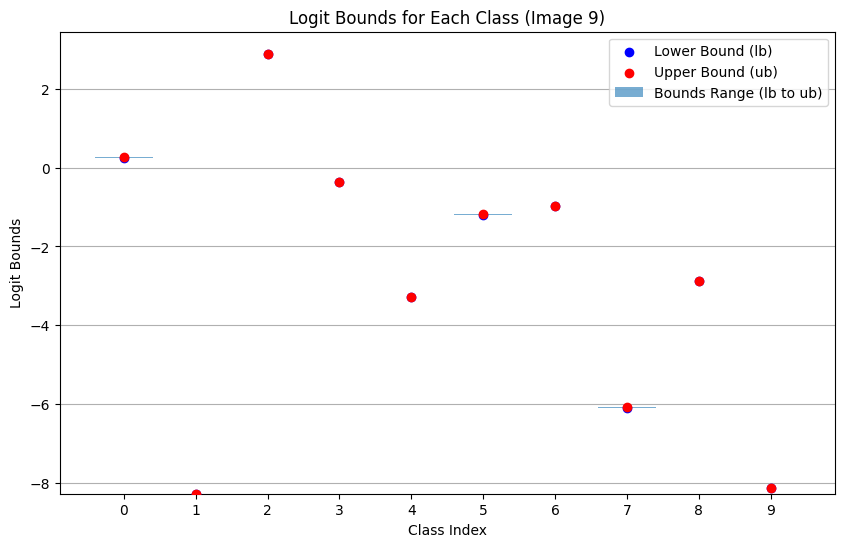

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Resize

# Function to convert MNIST grayscale image to RGB
def convert_to_rgb(image):
    return image.repeat(3, 1, 1)  # Convert grayscale to 3-channel by repeating

# Function to mask the perturbation to a 3x3 region
def localized_perturbation(eps, mask_location, image_size=(32, 32)):
    mask = torch.zeros(*image_size)
    x, y = mask_location
    mask[x:x+3, y:y+3] = eps  # Apply perturbation within a 3x3 region
    return mask.cpu()

# Auxiliary function to print bounds
def print_bounds(lb, ub):
    lb = lb.detach().cpu().numpy()
    ub = ub.detach().cpu().numpy()
    for j in range(10):  # Assuming a 10-class model
        print(f"f_{j}(x_0): {lb[0][j]:8.3f} <= f_{j}(x_0+delta) <= {ub[0][j]:8.3f}")

# Function to plot bounds
def plot_bounds(lb, ub, image_idx):
    lb = lb.detach().cpu().numpy()
    ub = ub.detach().cpu().numpy()
    x = np.arange(len(lb[0]))  # Class indices
    plt.figure(figsize=(10, 6))
    plt.bar(x, ub[0] - lb[0], bottom=lb[0], alpha=0.6, label='Bounds Range (lb to ub)')
    plt.scatter(x, lb[0], color='blue', label='Lower Bound (lb)', zorder=5)
    plt.scatter(x, ub[0], color='red', label='Upper Bound (ub)', zorder=5)
    plt.xlabel('Class Index')
    plt.ylabel('Logit Bounds')
    plt.title(f'Logit Bounds for Each Class (Image {image_idx})')
    plt.xticks(x)
    plt.legend()
    plt.grid(axis='y')
    plt.show()

# Step 1: Load MNIST data
test_data = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

# Step 2: Define global parameters
eps = 0.0008  # Perturbation epsilon
norm = np.inf  # L∞ norm
resize_transform = Resize((32, 32))  # Resize to match CIFAR model input size

# Loop through the first 5 images in the dataset
for i in range(10):
    image, label = test_data[i]  # Get the i-th image and label

    # Preprocess image: resize and convert to RGB
    image = resize_transform(image)  # Resize image to (32, 32)
    image = convert_to_rgb(image).unsqueeze(0).cpu()  # Convert to RGB and add batch dimension

    # Specify the perturbation mask location (e.g., top-left corner of the image)
    mask_location = (21, 12)  # Starting location of the 3x3 kernel
    perturbation_mask = localized_perturbation(eps, mask_location, image_size=(32, 32))

    # Define perturbation with localized mask
    ptb = PerturbationLpNorm(norm=norm, eps=eps, x_L=image - perturbation_mask, x_U=image + perturbation_mask)

    # Define BoundedModule and BoundedTensor
    bounded_model = BoundedModule(model=model, global_input=torch.zeros_like(image))
    bounded_image = BoundedTensor(x=image, ptb=ptb)

    # Compute bounds using CROWN method
    with torch.no_grad():
        lb, ub = bounded_model.compute_bounds(x=(bounded_image,), method='CROWN')

    # Print bounds and predictions
    print(f'\nImage Index: {i}')
    print('Ground-truth label:', label)
    output = model(image)
    _, predicted_label = torch.max(output, 1)
    print(f'Model prediction: {predicted_label.item()}')
    print_bounds(lb, ub)

    # Plot bounds
    plot_bounds(lb, ub, image_idx=i)


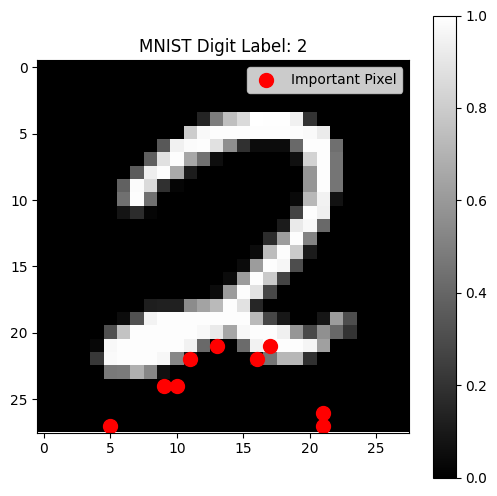

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

# Load the MNIST dataset
#test_data = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
image, label = test_data[35]  # Pick the first test image (modify index if needed)

# Important features (flattened indices) and their corresponding pixel locations
important_indices = [601, 605, 627, 632, 681, 682, 749, 761, 777]
image_width = 28
pixel_locations = [(index // image_width, index % image_width) for index in important_indices]

# Convert image to numpy array for plotting
image_np = image.squeeze().numpy()  # Remove batch and channel dimensions

# Plot the image
plt.figure(figsize=(6, 6))
plt.imshow(image_np, cmap='gray', interpolation='none')
plt.title(f'MNIST Digit Label: {label}')
plt.colorbar()

# Mark the important pixels
for (row, col) in pixel_locations:
    plt.scatter(col, row, color='red', s=100, label='Important Pixel')

# Avoid duplicate legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

# Display the plot
plt.show()


In [ ]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torchvision.transforms import Resize
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm
import matplotlib.pyplot as plt

# Step 1: Define global parameters
eps = 0.08  # Perturbation epsilon
resize_transform = Resize((32, 32))  # Resize to match CIFAR model input size

# Step 2: Define important pixel locations (28x28) and map to 32x32
important_indices = [601, 605, 627, 632, 681, 682, 749, 761, 777]
image_width = 28
scale = 32 / 28

# Map important pixels to 32x32 grid
pixel_locations_28x28 = [(index // image_width, index % image_width) for index in important_indices]
pixel_locations_32x32 = [(int(row * scale), int(col * scale)) for row, col in pixel_locations_28x28]

# Function to create localized perturbation
def apply_localized_perturbation(image, locations, kernel_size=3, eps=0.08):
    perturbed_image = image.clone()
    pad = kernel_size // 2
    for row, col in locations:
        row_start, row_end = max(row - pad, 0), min(row + pad + 1, 32)
        col_start, col_end = max(col - pad, 0), min(col + pad + 1, 32)
        perturbed_image[:, :, row_start:row_end, col_start:col_end] += torch.rand(
            row_end - row_start, col_end - col_start, device=image.device
        ) * eps
    return perturbed_image

# Step 3: Custom Perturbation Object
class LocalizedPerturbation:
    def __init__(self, perturbed_image):
        self.perturbed_image = perturbed_image

    def apply(self, x):
        return self.perturbed_image

# Step 4: Load test dataset
test_data = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

# Loop through the first 10 images in the dataset
for i in range(10):
    image, label = test_data[i]  # Get the i-th image and label

    # Preprocess image: resize and convert to RGB
    image = resize_transform(image)  # Resize image to (32, 32)
    image = image.repeat(3, 1, 1)  # Convert to RGB by repeating grayscale channel
    image = image.unsqueeze(0).cuda()  # Add batch dimension

    # Apply localized perturbation
    perturbed_image = apply_localized_perturbation(image, pixel_locations_32x32, eps=eps)

    # Define BoundedModule and BoundedTensor
    bounded_model = BoundedModule(model, global_input=torch.zeros_like(image))
    localized_ptb = LocalizedPerturbation(perturbed_image)
    bounded_image = BoundedTensor(x=image, ptb=localized_ptb)

    # Compute bounds
    with torch.no_grad():
        lb, ub = bounded_model.compute_bounds(x=(bounded_image,), method='CROWN')

    # Print bounds and prediction
    output = model(perturbed_image)
    _, predicted_label = torch.max(output, 1)
    print(f"Image {i + 1}:")
    print(f"  Ground-truth label: {label}")
    print(f"  Model prediction: {predicted_label.item()}")

    # Auxiliary function to print bounds
    def print_bounds(lb, ub):
        lb = lb.detach().cpu().numpy()
        ub = ub.detach().cpu().numpy()
        for j in range(10):  # Assuming a 10-class model
            print(f"  f_{j}(x_0): {lb[0][j]:8.3f} <= f_{j}(x_0+delta) <= {ub[0][j]:8.3f}")

    print_bounds(lb, ub)

    # Optional: Visualize bounds for each image
    def plot_bounds(lb, ub):
        lb = lb.detach().cpu().numpy()
        ub = ub.detach().cpu().numpy()
        x = np.arange(len(lb[0]))  # Class indices
        plt.figure(figsize=(10, 6))
        plt.bar(x, ub[0] - lb[0], bottom=lb[0], alpha=0.6, label='Bounds Range (lb to ub)')
        plt.scatter(x, lb[0], color='blue', label='Lower Bound (lb)', zorder=5)
        plt.scatter(x, ub[0], color='red', label='Upper Bound (ub)', zorder=5)
        plt.xlabel('Class Index')
        plt.ylabel('Logit Bounds')
        plt.title(f'Logit Bounds for Image {i + 1}')
        plt.xticks(x)
        plt.legend()
        plt.grid(axis='y')
        plt.show()

    plot_bounds(lb, ub)


AttributeError: 'LocalizedPerturbation' object has no attribute 'init'

The backward mode perturbation analysis (an extension of [CROWN](https://https://arxiv.org/pdf/1811.00866.pdf)) provides relatively tight bounds. In this example above, the ground-truth label is 2. You can see that the model logit output for label 2 is bounded between 1.883 and 7.537, and we can guarantee that its the top-1 label under perturbation.

Next, we will compute the bounds using interval bound propagation (IBP), a previous approach that can also operate on general computational graphs. However, it produces much looser and vacuous bounds:

In [ ]:
# Our library also supports the interval bound propagation (IBP) based bounds,
# but it produces much looser bounds.
print('Bounding method: IBP')
with torch.no_grad():
  lb, ub = bounded_model.compute_bounds(x=(bounded_image,), method='IBP')

print_bounds(lb, ub)

Bounding method: IBP
f_0(x_0): -26653354.000 <= f_0(x_0+delta) <= 16529142.000
f_1(x_0): -28404330.000 <= f_1(x_0+delta) <= 18456214.000
f_2(x_0): -20085348.000 <= f_2(x_0+delta) <= 15208612.000
f_3(x_0): -19151258.000 <= f_3(x_0+delta) <= 10512926.000
f_4(x_0): -24811492.000 <= f_4(x_0+delta) <= 13541444.000
f_5(x_0): -24154548.000 <= f_5(x_0+delta) <= 14438838.000
f_6(x_0): -27285224.000 <= f_6(x_0+delta) <= 12938548.000
f_7(x_0): -31904954.000 <= f_7(x_0+delta) <= 19278454.000
f_8(x_0): -32637672.000 <= f_8(x_0+delta) <= 19319444.000
f_9(x_0): -27241750.000 <= f_9(x_0+delta) <= 13883126.000


## Differentiability of our bounds

The bounds obtained by our `compute_bounds()` method are themselves differentiable w.r.t. input image or model parameters. We can obtain the gradients easily just as we usually do in Pytorch.  The gradients can be used for certified defense training. See our [training examples](https://github.com/KaidiXu/auto_LiRPA#basic-certified-training).


In [ ]:
bounded_model.zero_grad()
lb, ub = bounded_model.compute_bounds(x=(bounded_image,), method='CROWN')
# Create a dummy scalar function for demonstrating the differentiability.
loss = lb.sum()
loss.backward()
# This is the gradients of the loss w.r.t. first convolutional layer's weights:
print('grad norm:', list(model.modules())[1].weight.grad.norm(2))

grad norm: tensor(97.1450, device='cuda:0')


## More examples

We provide many examples of `auto_LiRPA` in our repository. You can find more details of these examples [here](https://github.com/KaidiXu/auto_LiRPA#more-working-examples). Notably, we provided the following examples for `auto_LiRPA`:

1. Certified defense on CIFAR-10, **TinyImageNet** and **ImageNet** (64*64) using large scale computer vision models such as DenseNet, ResNeXt and WideResNet.
2. Examples on using **loss fusion**, an efficient technique that scales linear relaxation based certified defense to large datasets, making certified defense training up to 1000 times faster compared to the previous approach.
3. Examples on training verifiably robust **LSTM** and **Transformer** models on natural language processing (**NLP**) tasks.
4. Examples on bounding network output given **model weight perturbations**. Existing frameworks can only handle perturbations on model inputs, not on model parameters (weights). This allows us to perform robustness verification or certified adversarial defense against weight perturbations. We can also train the bounds on model weights to obtain models with flat optimization landscapes.